In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')


### Import Data

In [2]:
aisles = pd.read_csv('data/aisles.csv')
department = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')


#preview data 
print('aisles table')
display(aisles.head())
print('department table')
display(department.head())

print('products table')
display(products.head())

print('orders table')
display(orders.head())
print('order_products_prior')
display(order_products_prior.head())
print('order_products_train table')
display(order_products_train.head())

aisles table


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


department table


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


products table


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


orders table


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


order_products_prior


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products_train table


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Data Exploration / Data Cleaning

#### aisle, department, products

Based on the relational database schema, lets first combine the aisle, department to the products table based on the aisle id and department id. 

In [3]:
# combine aisle, department tables to products

products1 = pd.merge(products, aisles, on='aisle_id', how='left')
products1 = pd.merge(products1, department, on='department_id', how='left')

#sanity check
display(products1.head())
display(products1.info())

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
 4   aisle          49688 non-null  object
 5   department     49688 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.7+ MB


None

In [4]:
#check on missing information for products1
products1.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64

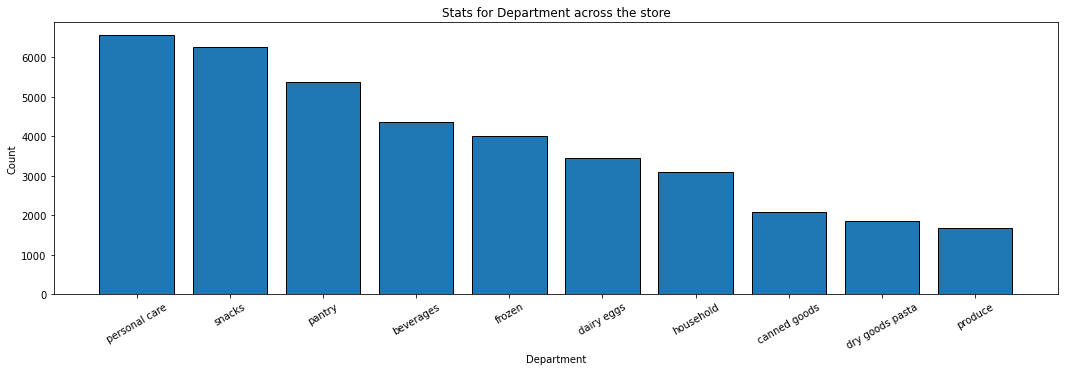

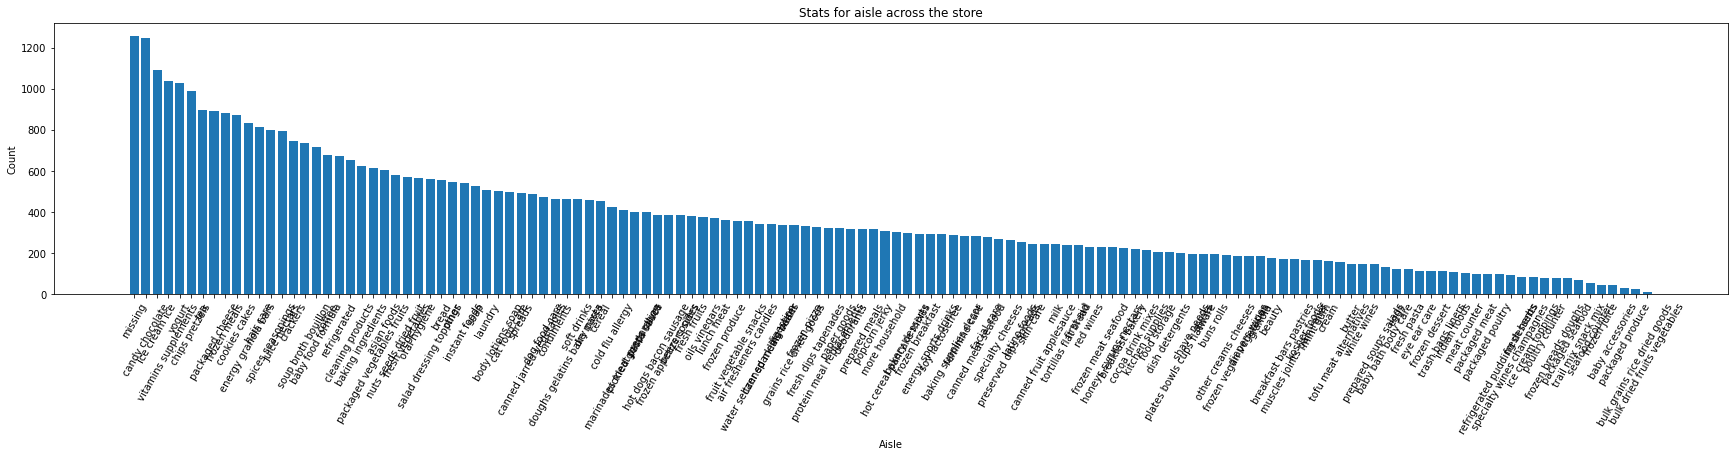

In [8]:
# Get the distribution of different aisle and department 

plt.figure(figsize = (18,5))
plt.bar(products1['department'].value_counts()[:10].index, products1['department'].value_counts()[:10].values, edgecolor ='black')
plt.title('Stats for Department across the store')
plt.ylabel('Count')
plt.xlabel('Department')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize = (30,5))
plt.bar(products1['aisle'].value_counts().index, products1['aisle'].value_counts().values)
plt.title('Stats for aisle across the store')
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.xticks(rotation=60)
plt.show()

In [5]:
products1['department'].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64

In [6]:
products1['aisle'].value_counts()

missing                         1258
candy chocolate                 1246
ice cream ice                   1091
vitamins supplements            1038
yogurt                          1026
                                ... 
frozen juice                      47
baby accessories                  44
packaged produce                  32
bulk grains rice dried goods      26
bulk dried fruits vegetables      12
Name: aisle, Length: 134, dtype: int64

Based on the aboved graph, we can tell that most of the products are belong to top 5 departments (personal care, snacks, pantry, beverages,and frozon). The aisle column may seem to be a little overwhlemd but we can se there are missing aisles and department. Lets see what items are those missing belone to. 

In [7]:
#get the missing aisle and department from products1 table
products1[products1['department']=='missing']

,product_id,product_name,aisle_id,department_id,aisle,department
37,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
71,72,Organic Honeycrisp Apples,100,21,missing,missing
109,110,Uncured Turkey Bologna,100,21,missing,missing
296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
416,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
49552,49553,Organic Plain Skyr,100,21,missing,missing
49574,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
49640,49641,"8\"" Pecan Pie",100,21,missing,missing
49663,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


In [8]:
# checking on some other similar products see which department and aisle they belong to
products1[products1['product_name'].isin(['Apples','Pecan Pie','Chocolate','Vinegar'])]

,product_id,product_name,aisle_id,department_id,aisle,department
13574,13575,Apples,24,4,fresh fruits,produce
17999,18000,Pecan Pie,8,3,bakery desserts,bakery
30128,30129,Vinegar,66,6,asian foods,international
38679,38680,Chocolate,45,19,candy chocolate,snacks


The missing aisle and department information seems to be not correctly sorted in the appropriate aisle and department. The data may need further classfied for those missing information. 

#### orders 

In [9]:
#getting a stats info about orders table

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [10]:
#checking on missing information 

orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

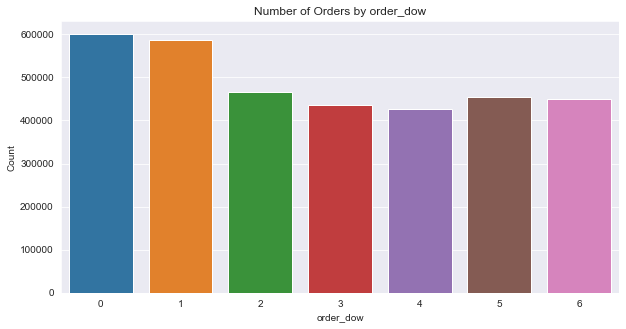

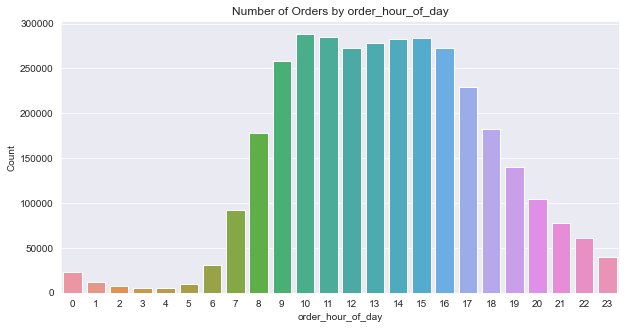

In [11]:
# order_dow, order_hour_of_day of distribution

plot =['order_dow','order_hour_of_day']

sns.set_style('darkgrid')

for items in plot:
    plt.figure(figsize=(10,5))
    sns.countplot(x=items, data=orders)
    plt.title(f'Number of Orders by {items}')
    plt.ylabel('Count')
    plt.xlabel(f'{items}')

plt.show()


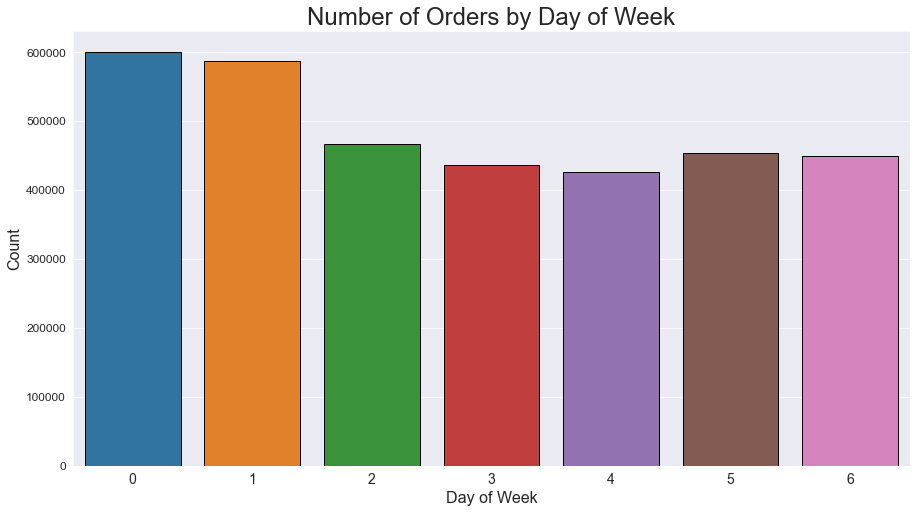

In [61]:
#modify the order_dow plot for PPT

plt.figure(figsize=(15,8))
sns.countplot(x='order_dow', data=orders, edgecolor='black')
plt.title(f'Number of Orders by Day of Week', fontsize=24,loc='center')
plt.ylabel('Count', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
plt.show()


Based on the graph, most people order on sunday and monday assuming day of week start with Sunday. Also it seems like the orders are evenly distributed throughout the week. However, base on the order by hour of day, it is interesting to see people actually placed orders during regular work hours specificlly from 9am to 11am and 1pm to 4pm. Lets further explore to see what are the distribution of order placed for the hour of day on weekdays vs weekend. 

In [22]:
#create new columns for weekend vs weekday indicator
orders['order_weekend']=np.NaN

#replace 1 for weekend 0 for weekday
orders.loc[orders['order_dow'].isin([0,6]), 'order_weekend']= 1
orders.loc[orders['order_dow'].isin([1,2,3,4,5]),'order_weekend']=0

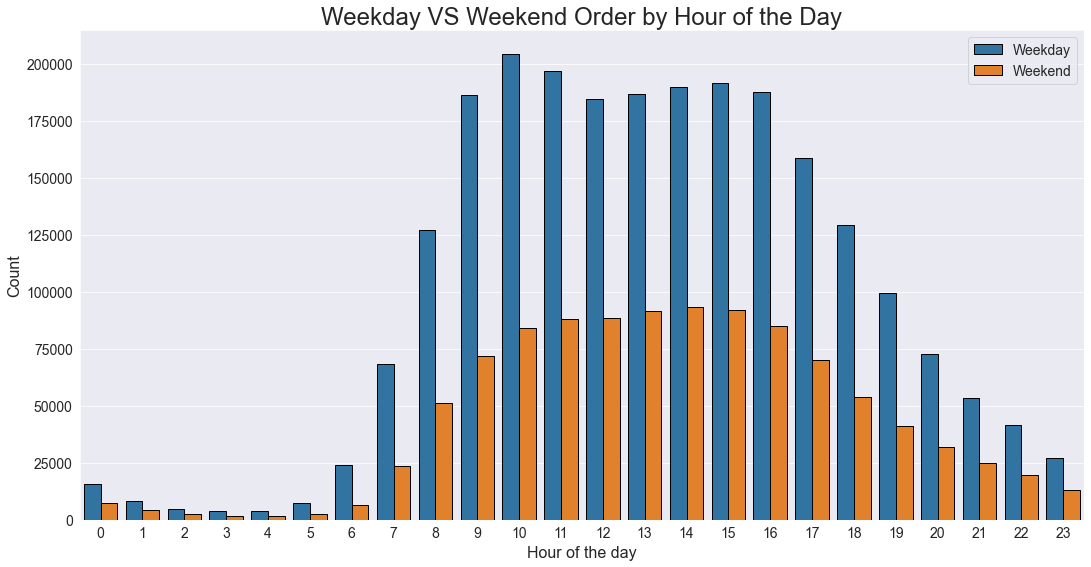

In [40]:
# create the chart to see the order would be differnet hours compared to weekday and weekend

sns.set_style('darkgrid')
plt.figure(figsize=(18,9))
sns.countplot(x='order_hour_of_day', data = orders, hue='order_weekend',edgecolor='black')
plt.xlabel('Hour of the day',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.title('Weekday VS Weekend Order by Hour of the Day',fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Weekday','Weekend'],loc='best', fontsize=14)
plt.show()


Based on the graph of the orders by hour of the day we can see that the majority of the orders are placed between 9am to 5pm regardless of weekend or weekday. However, surprisingly more people placed the order during the weekday especially during regular working hours. 

Text(0.5, 1.0, 'Proportion of order by hour for Weekday vs Weekend')

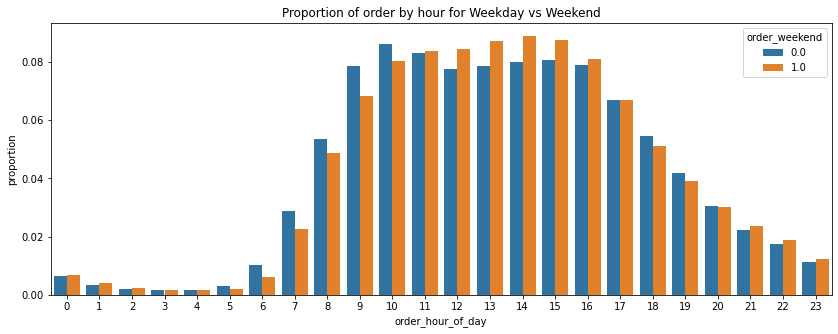

In [18]:
# Plot the proportion orders by hour of day for weekday vs weekend 
# Weekday orders by hour of day 

x,y,hue ='order_hour_of_day','proportion','order_weekend'
hue_order = ['Weekday','Weekend']

plt.figure(figsize=(14,5))
orders[x].groupby(orders[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, 'data'),x=x, y=y, hue=hue)
plt.xlabel('order_hour_of_day')
plt.ylabel('proportion')
plt.title('Proportion of order by hour for Weekday vs Weekend')

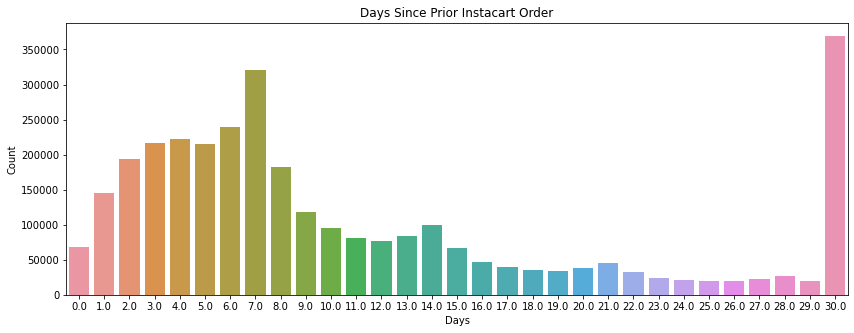

In [9]:
# plot the distribution of the days since prior instacart orders
plt.figure(figsize = (14,5))
sns.countplot(x='days_since_prior_order', data= orders)
plt.title('Days Since Prior Instacart Order')
plt.ylabel('Count')
plt.xlabel('Days')
plt.show()

#### order_products_prior, order_products_train

Next I will review the order_products_prior information and combine the products table, department, aisle, orders all together.

In [41]:
##combine orders_products_train and products1 to one table
orders_train = pd.merge(order_products_train, products1, on='product_id', how='left')

# combine orders_train and orders to one table
orders_train = pd.merge(orders_train,orders,on='order_id',how='left')

#sanity check on the combined table
print(f' Shape of order_products_train: {order_products_train.shape}')
print(f' Shape of products1: {products1.shape}')
print(f' Shape of orders: {orders.shape}')
print(f' Shape of orders_train: {orders_train.shape}')

#preview the orders_train table

orders_train.head()

 Shape of order_products_train: (1384617, 4)
 Shape of products1: (49688, 6)
 Shape of orders: (3421083, 8)
 Shape of orders_train: (1384617, 16)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_weekend
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0,0.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0,0.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,0.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0,0.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0,0.0


In [44]:
##combine orders_products_prior and products1 to one table
orders_prior = pd.merge(order_products_prior, products1, on='product_id', how='left')

# combine orders_prior and orders to one table
orders_prior = pd.merge(orders_prior,orders,on='order_id',how='left')

#sanity check on the combined table
print(f' Shape of order_products_prior: {order_products_prior.shape}')
print(f' Shape of products1: {products1.shape}')
print(f' Shape of orders: {orders.shape}')
print(f' Shape of orders_prior: {orders_prior.shape}')

#preview the orders_prior table

orders_prior.head()

 Shape of order_products_prior: (32434489, 4)
 Shape of products1: (49688, 6)
 Shape of orders: (3421083, 8)
 Shape of orders_prior: (32434489, 16)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_weekend
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,0.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,0.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,0.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,0.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,0.0


In [46]:
# checking on basic information for orders_prior table

print('Orders_prior Table info')
display(orders_prior.info())

Orders_prior Table info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 16 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
 15  order_weekend           float64
dtypes: float64(2), int64(10), object(4)
memory usage: 4.1+ GB


None

In [47]:
print('Missing information for orders_prior')
display(orders_prior.isnull().sum())

Missing information for orders_prior


order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
order_weekend                   0
dtype: int64

It appears that the only missing information is the days_since_prior_order. It mainly because some of the products that a user ordered for the first time. Therefore, those product related to that particular user will appear as NA. I will fill those NA with 0 later. Filling those missing values with 0 does not seem to have impact on my analysis since I also have a reorder indicator. If the reorder is 0 then it make sence that the user never order before. Therefore days since prior order should be 0. 

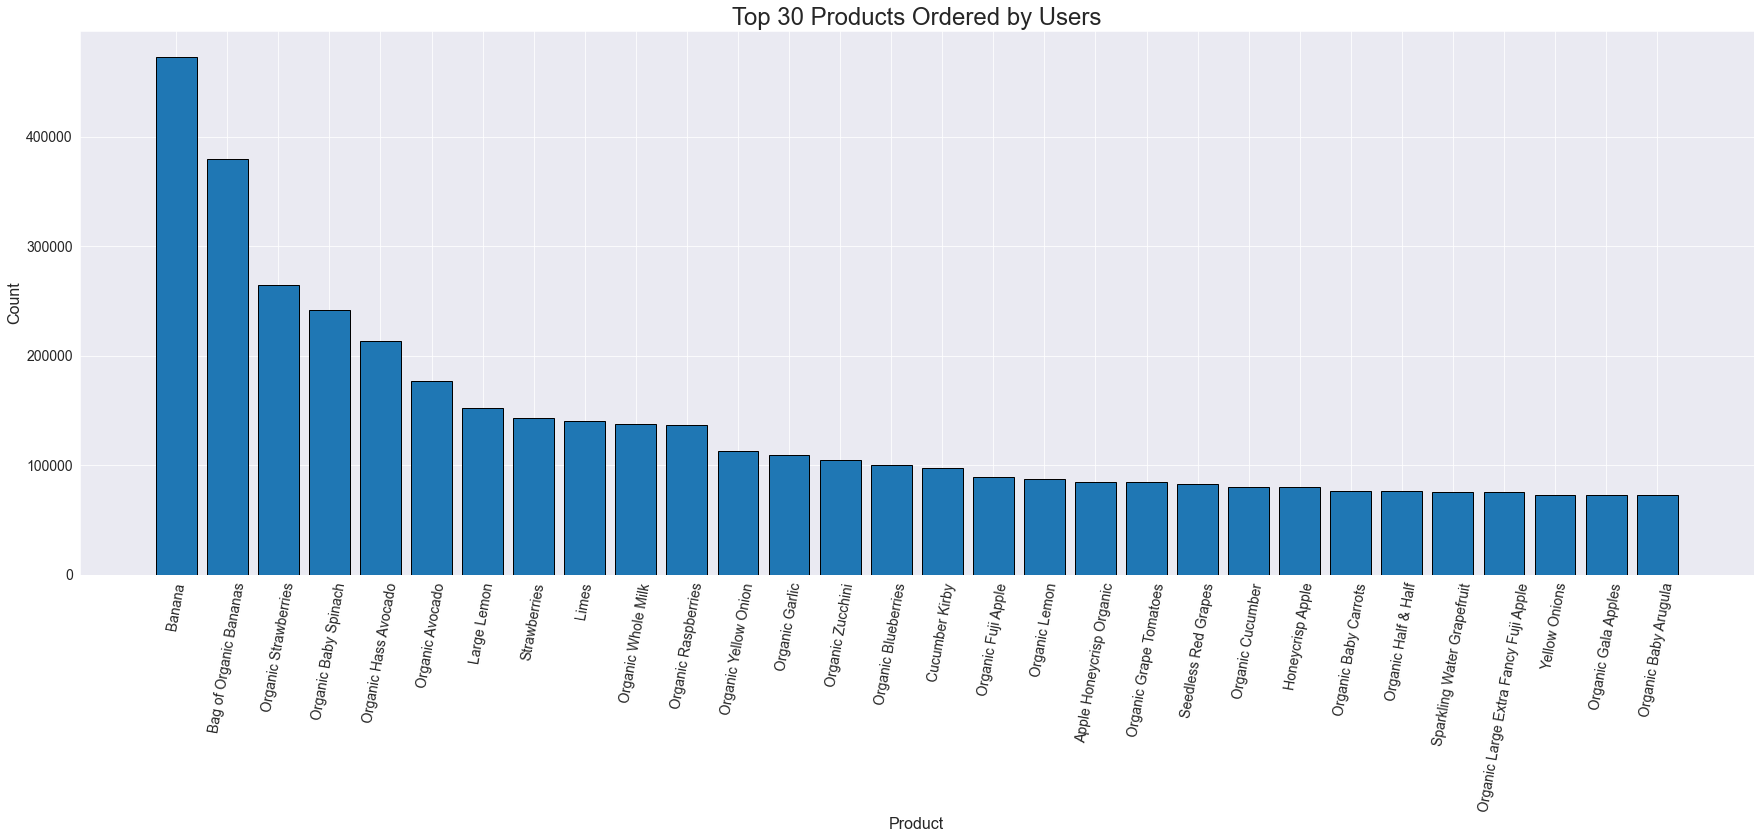

In [51]:
# explore the top 30 products ordered by customer
top30_products = orders_prior['product_name'].value_counts()[:30]

plt.figure(figsize=(30,10))
sns.set_style('darkgrid')
plt.bar(top30_products.index, top30_products.values, edgecolor ='black')
plt.title('Top 30 Products Ordered by Users', fontsize=24)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Product',fontsize=16)
plt.xticks(rotation=80, fontsize=14)
plt.yticks(fontsize=14)
plt.show()


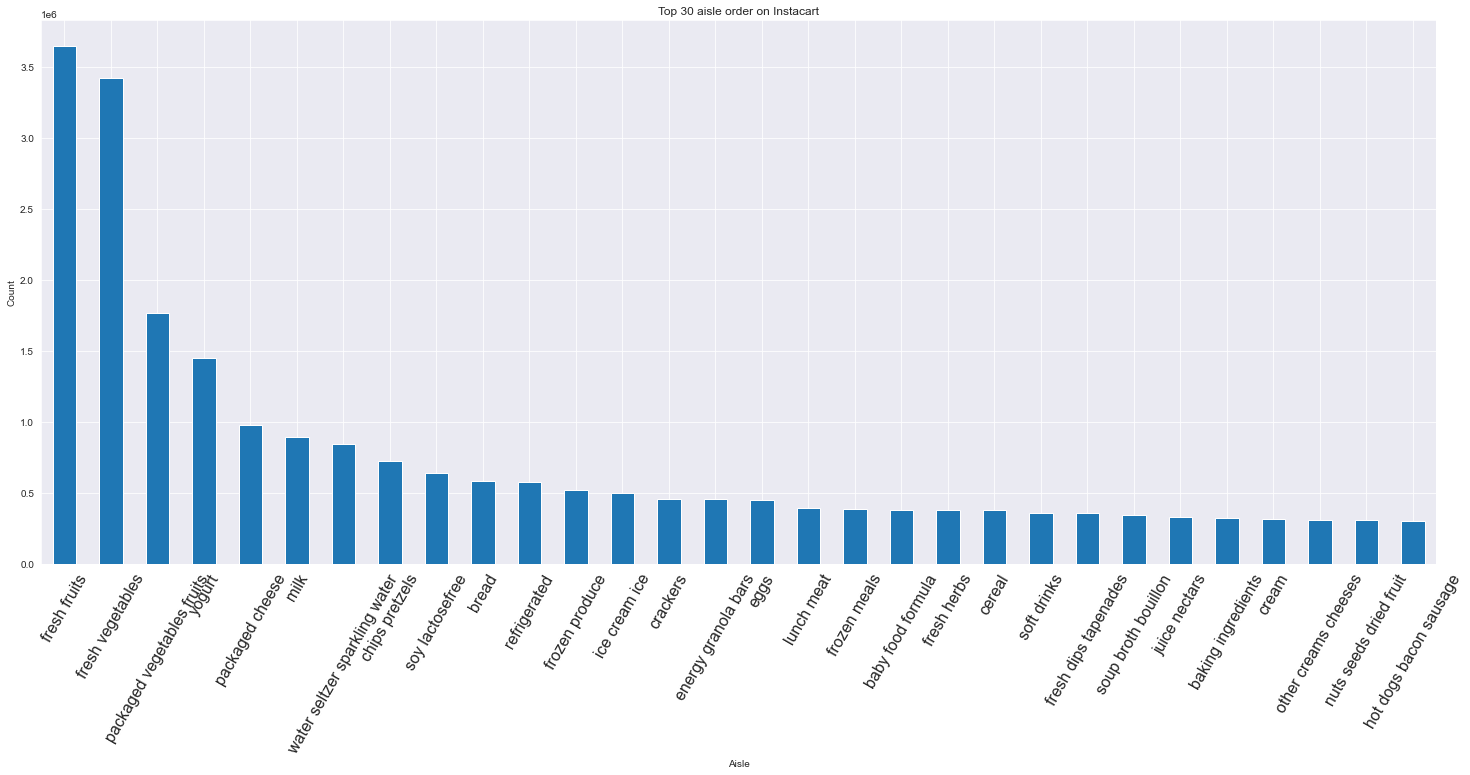

In [53]:
# explore the top 30 aisle ordered by customer
top30_aisle = orders_prior['aisle'].value_counts()[:30]

plt.figure(figsize=(25,10))
top30_aisle.plot(kind='bar')
plt.title('Top 30 aisle order on Instacart')
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.xticks(rotation=60, fontsize=16)
plt.show()

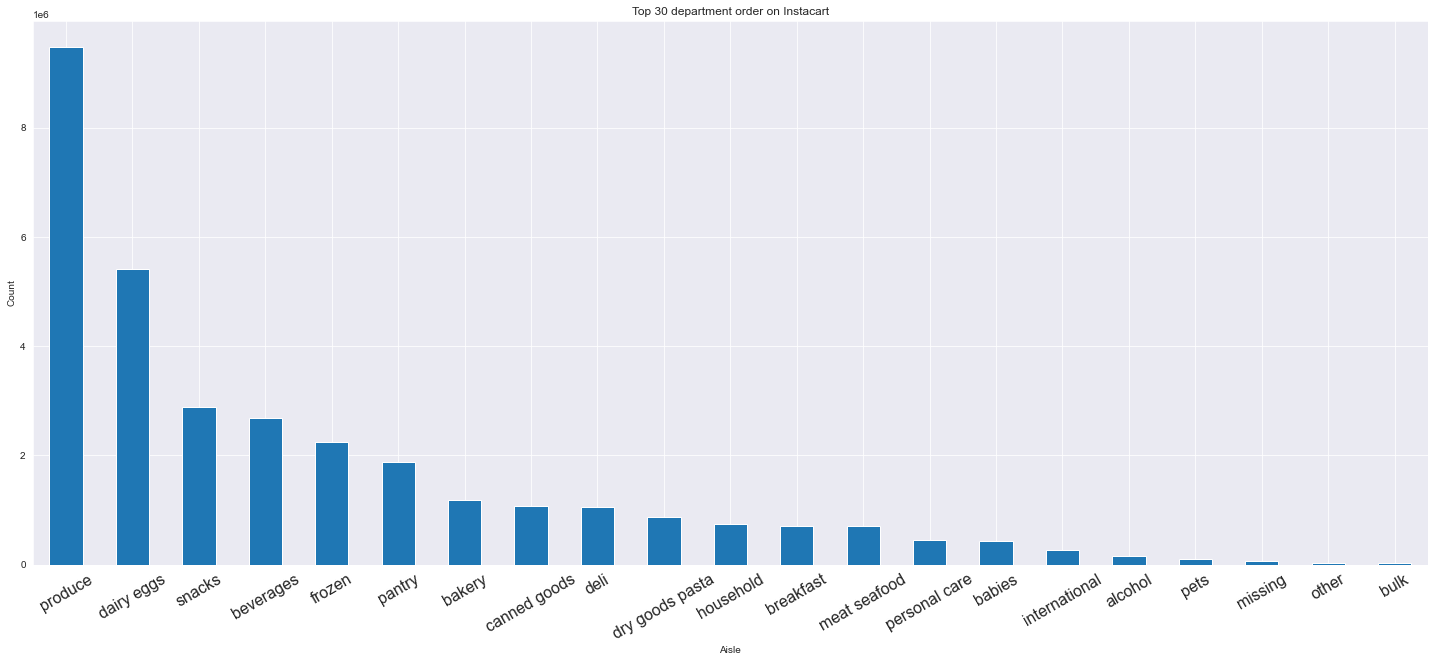

In [54]:
# explore the top 30 aisle ordered by customer
top30_department = orders_prior['department'].value_counts()[:30]

plt.figure(figsize=(25,10))
top30_department.plot(kind='bar')
plt.title('Top 30 department order on Instacart')
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.xticks(rotation=30, fontsize = 16)
plt.show()

In [59]:
# calculate the total number of unique users in the orders_prior
print(f'Number of Unique Users in Orders_prior: {len(orders_prior["user_id"].unique())}')

Number of Unique Users in Orders_prior: 206209


In [55]:
# calculate the reorder ratio in order_prior

orders_prior['reordered'].value_counts(normalize=True)

1    0.589697
0    0.410303
Name: reordered, dtype: float64

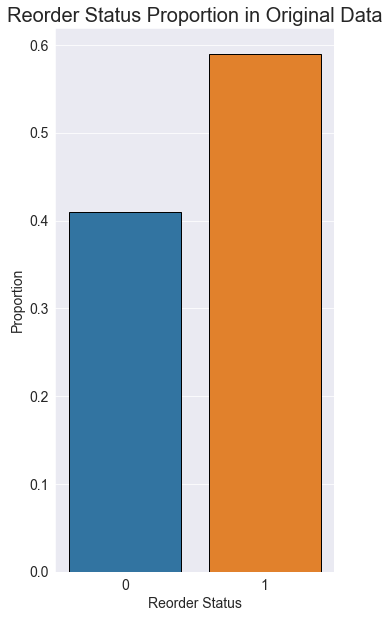

In [62]:
#plot the reorder ratio
sns.set_style('darkgrid')
plt.figure(figsize=(5,10))
sns.barplot(orders_prior['reordered'].value_counts().index, orders_prior['reordered'].value_counts(normalize=True).values, edgecolor='black')
plt.xlabel('Reorder Status', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14,)
plt.title('Reorder Status Proportion in Original Data', fontsize=20)
plt.show()

The reordered ratio in the order_prior data seems to be balanced. 

In [94]:
## export the orders_train data for later use

orders_train.to_csv('data/orders_train.csv', index=False)
orders_prior.to_csv('data/orders_prior.csv', index=False)

This is a relatively large dataset. In order to save some computing speed and to develop the models I have decided to to choose 10,000 users data (about 5% observations) from the order_prior data.

In [ ]:
#get a sample of 10000 users from the df
df = orders_prior[orders_prior['user_id'].isin(range(1,10001))].reset_index(drop=True)

df.to_csv('data/sample.csv')